In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Лабораторная №5 - Проведение исследований с алгоритмом Градиентный бустинг

## 1.Выбор начальных условий

In [6]:
pd.options.display.max_columns = None
data_classification = pd.read_csv('class_data/stackoverflow_full.csv').drop('Unnamed: 0', axis=1) #Выгрузка csv с данными классификации

files = ['FOOD-DATA-GROUP1.csv', 'FOOD-DATA-GROUP2.csv', 'FOOD-DATA-GROUP3.csv', 'FOOD-DATA-GROUP4.csv', 'FOOD-DATA-GROUP5.csv']
data_reg = pd.concat((pd.read_csv(f'reg_data/{f}') for f in files), ignore_index=True).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1) #объединение и выгрузка сразу всех файлов с данными регрессии

Для оценки качества Классификации будем использовать такие же метрики как в прошлой работе: 
- Accuracy (Процент правильных предсказаний)
- F1-Score (важная метрика если классы несбалансированны)
- Confusion Matrix (Матрица которая покажет полную карту в работе модели)

Для оценки качества Регрессии будем использовать такие же базовые метрики как и в прошлой работе:

- RMSE (показывает типичный размер ошибки в исходных единицах) 
- MAE (устойчива к выбросам)
- R^2 (показывает общее качество модели)

## 2.Создание бейзлайна и оценка качества

Перед созданием и обучением модели, нам надо немного почистить и закодировать данные в датафрейме Классификации, тк модель не сможет работать с object признаками. Датафрейм регрессии уже готов для обучения модели.

In [12]:
def encoder_data(data: pd.DataFrame):
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    Ordinal = OrdinalEncoder()
    
    if 'HaveWorkedWith' in data.columns:
        tech_dummies = data['HaveWorkedWith'].str.get_dummies(sep=';')
        data = pd.concat([data, tech_dummies], axis=1)
        data = data.drop('HaveWorkedWith', axis=1)
    
    categorical_features = data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        
        if data[col].nunique() == 2:
            col_encoded = onehot.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=onehot.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
            
        else:
            col_encoded = Ordinal.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=Ordinal.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
    return data

data_classification_encoded = encoder_data(data_classification)

После всей кодировки данных перейдём к обучению моделей. Разделим данные на тренировочные и тестовые для обучения и проверки метрик на данных которые модель ещё не видела и приступим к обучению

In [14]:
y_classification = data_classification_encoded['Employed']
x_classification = data_classification_encoded.drop('Employed', axis = 1)

y_reg = data_reg['Nutrition Density']
x_reg = data_reg.drop(['Nutrition Density','food'], axis=1)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(x_classification, y_classification, test_size=0.33, 
                                                                                                                random_state=42) # разделение данных на тестовые и обучающие выборки

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.33, random_state=42)

Далее Создадим модели Градиентного бустинга и обучим их

In [17]:
classification_model = GradientBoostingClassifier() #модель Градиентного бустинга для классификации
Reg_model = GradientBoostingRegressor() #Модель Градиентного бустинга для регрессии

classification_model_fit = classification_model.fit(X_train_classification, y_train_classification) # обучение модели Классификации
Reg_model_fit = Reg_model.fit(X_train_reg, y_train_reg) # Обучение модели Регрессии

classification_predict = classification_model_fit.predict(X_test_classification) # Предсказываем для дальнейшего просмотра метрик
reg_predict = Reg_model_fit.predict(X_test_reg)

Метрики Градиентного бустинга для классификации: 
Accuracy - 0.9931939116445985 
f1 - 0.9936212162214405



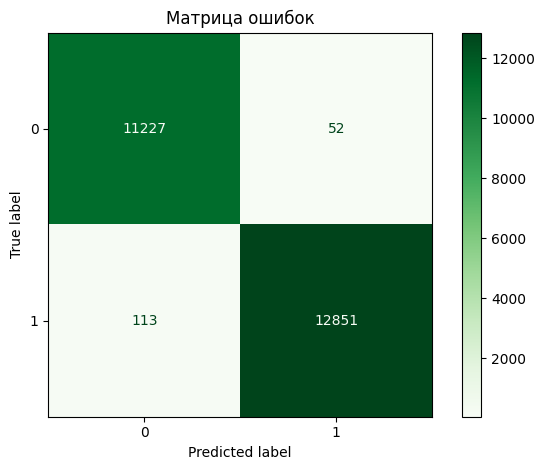

Метрики Градиентного бустинга регрессии: 
MAE - 10.62648053517701 
R^2 - 0.9682302937536178
RMSE - 27.319487171462196



In [18]:
def metrics_class(true, predict):
    print(f'Метрики Градиентного бустинга для классификации: \n'
          f'Accuracy - {accuracy_score(true, predict)} \n'
          f'f1 - {f1_score(true, predict)}\n')

    matrix = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Greens', values_format='d')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

metrics_class(y_test_classification, classification_predict)

def metric_reg(true, predict):
        print(f'Метрики Градиентного бустинга регрессии: \n'
          f'MAE - {mean_absolute_error(true, predict)} \n'
          f'R^2 - {r2_score(true, predict)}\n'
          f'RMSE - {np.sqrt(mean_squared_error(true, predict))}\n')
metric_reg(y_test_reg, reg_predict)

##### Метрики для бинарной классификации оказались следующими:
- Accuracy - 0.993 Очень высокий результат и очень подозрительный, похож на ситуацию с обычным деревом, скорее всего это переобучение модели
- f1 - 0993 Так же очень подозрительный результат который потом надо будет проверить.
##### Метрики для регрессии оказались следующими:
- MAE - 10.6 означает, что средняя ошибка составляет 10.6 единицы, что является прекрасный результатом
- R² - 0.96 модель объясняет 96% дисперсии целевой переменной. Хороший результат, но есть подозрения на переобучение, поэтому в новом бейзлайне проверим это
- RMSE - 27.3 стандартное отклонение ошибок 27.3 единицы.

## 3.Улучшение бейзлайна

##### Модели себя показали хорошо, но есть подозрения на переобучения, попробуем подобрать гиперпараметры (Ограничение по параметрам) к модели и использовать кросс-валидацию для избежания переобучения 
- Происк оптимальных гиперпараметров и Кросс-валидация
##### Что мы делать не будем, в отличи от других работ:
- Избавляться от мультиколлинерности в данных, Градиентный бустинг устойчив к такому
- Не будем масштабировать данные, так это может быть даже вредно для Древоподобных моделей (Они работают с порядком, а не величинами).

### Найдём гиперпараметры модели с кросс-валидацией

##### Параметры для Градиентного Бустинга:
- n_estimators - Количество деревьев (итераций бустинга)
- learning_rate - Скорость обучения (шаг)
- max_depth - Максимальная глубина
- subsample - Доля samples для обучения каждого дерева
- min_samples_split - Минимальное samples для разделения
- loss (Только для регресси) - Функция потерь

In [19]:
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.07],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
    'min_samples_split': [20, 50],
}

gb_reg_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.07],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
    'loss': ['squared_error', 'absolute_error'],  # Разные функции потерь
    'min_samples_split': [20, 50]
}

model_class = GradientBoostingClassifier()
grid_class = GridSearchCV(estimator=model_class, param_grid=gb_params,cv=5) 

model_reg = GradientBoostingRegressor()
grid_reg = GridSearchCV(estimator=model_reg, param_grid=gb_reg_params, cv=5)

Grad_Class = grid_class.fit(X_train_classification, y_train_classification)
Grad_Reg = grid_reg.fit(X_train_reg, y_train_reg)

Подобрали гиперпараметры и обучили модели с использованием Кросс-валидации

Метрики Градиентного бустинга для классификации: 
Accuracy - 0.9994225137152992 
f1 - 0.9994598348638012



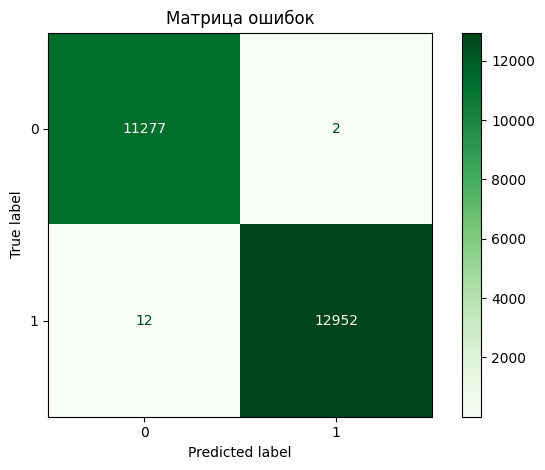

Метрики Градиентного бустинга регрессии: 
MAE - 10.18302210125737 
R^2 - 0.9648461909836098
RMSE - 28.737708657228094



In [21]:
predict_class = Grad_Class.predict(X_test_classification)
predict_reg = Grad_Reg.predict(X_test_reg)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Данные метрики мало чем отличаются от прошлых результатов, они стали чуть лучше, но это может означать лишь переобучение нашей модели, что не есть хорошо. Accuracy в классификации 0.999 крайне подозрительное значение. В регрессии же всё не так плохо, MAE = 10.18 и R^2 = 0.96 это очень сильный результат, но не назвать явным переобучением.

# 4.Имплементация алгоритма машинного обучения 

Для начала создадим базовую модель для градиентного бустинга, такой моделью будет Дерево решений с 3 лабораторной работы, далее уже напишем сам ансамбль и обучим его

- Базовое дерево решений которое будет использоваться в Ансамбле
- Сам Ансабль Градиентный бустинг
- Подбор Гиперпараметров к нему

In [22]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, mode="classification"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.mode = mode
        self.tree = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value  # для листа

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return self.Node(value=self._leaf_value(y))

        best_feat, best_thresh, best_score = None, None, np.inf
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left_mask = X[:, feat] <= t
                right_mask = X[:, feat] > t
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue  # Пропускаем это разбиение
                y_left, y_right = y[left_mask], y[right_mask]
                score = self._impurity(y_left, y_right)
                if score < best_score:
                    best_feat, best_thresh, best_score = feat, t, score

        if best_feat is None:
            return self.Node(value=self._leaf_value(y))

        left_node = self._build_tree(X[X[:, best_feat] <= best_thresh], y[X[:, best_feat] <= best_thresh], depth+1)
        right_node = self._build_tree(X[X[:, best_feat] > best_thresh], y[X[:, best_feat] > best_thresh], depth+1)
        return self.Node(best_feat, best_thresh, left_node, right_node)

    def _impurity(self, y_left, y_right):
        if self.mode == "classification":
            return (len(y_left)*self._gini(y_left) + len(y_right)*self._gini(y_right)) / (len(y_left)+len(y_right))
        else:
            return (len(y_left)*self._variance(y_left) + len(y_right)*self._variance(y_right)) / (len(y_left)+len(y_right))

    def _gini(self, y):
        counts = np.bincount(y.astype(int))
        p = counts / counts.sum()
        return 1 - np.sum(p**2)

    def _variance(self, y):
        return np.var(y)

    def _leaf_value(self, y):
        # Если y пустой — возвращаем 0 или мод (для классификации)
        if len(y) == 0:
            return 0 if self.mode == "regression" else 1
    
        if self.mode == "classification":
            return Counter(y).most_common(1)[0][0]
        else:
            return float(np.mean(y))

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

Далее напишем класс Градиентного бустинга

In [24]:
from collections import Counter

class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, task='regression'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task  # 'regression' or 'classification'
        self.trees = []
        self.initial_prediction = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, verbose=False):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        if self.task == 'regression':
            self.initial_prediction = np.mean(y)
            current_predictions = np.full_like(y, self.initial_prediction, dtype=float)
    
            for i in range(self.n_estimators):
                residuals = y - current_predictions  # gradient (MSE)
    
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    mode="regression"
                )
                tree.fit(X, residuals)
    
                # update only on the fold's X
                update = tree.predict(X)
    
                current_predictions += self.learning_rate * update
    
                self.trees.append(tree)
    
                if verbose and i % 20 == 0:
                    mse = np.mean((y - current_predictions)**2)
                    print(f"[Reg] Iter {i}, MSE: {mse:.3f}")
    
            return self
    
        elif self.task == 'classification':
            y = y.astype(int)
    
            # initial log-odds
            p = np.clip(np.mean(y), 1e-6, 1 - 1e-6)
            self.initial_prediction = np.log(p / (1 - p))
    
            current_logits = np.full_like(y, self.initial_prediction, dtype=float)
    
            for i in range(self.n_estimators):
                # prob = sigmoid(logits)
                prob = 1 / (1 + np.exp(-current_logits))
    
                # gradient of logistic loss
                gradient = y - prob
    
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    mode="regression"
                )
                tree.fit(X, gradient)
    
                update = tree.predict(X)
                current_logits += self.learning_rate * update
    
                self.trees.append(tree)
    
                if verbose and i % 20 == 0:
                    loss = -np.mean(
                        y*np.log(prob + 1e-9) + (1-y)*np.log(1 - prob + 1e-9)
                    )
                    print(f"[Clf] Iter {i}, LogLoss: {loss:.3f}")
    
            return self
    
    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        base = np.full(X.shape[0], self.initial_prediction)

        for tree in self.trees:
            base += self.learning_rate * tree.predict(X)
        if self.task == 'regression':
            return base
            
        prob = self._sigmoid(base)
        return (prob > 0.5).astype(int)

    def predict_proba(self, X):
        """Вероятности только для классификации."""
        if self.task != 'classification':
            raise ValueError("predict_proba доступно только для классификации")
        
        X = X.values if isinstance(X, pd.DataFrame) else X
        
        base = np.full(X.shape[0], self.initial_prediction)
        for tree in self.trees:
            base += self.learning_rate * tree.predict(X)

        prob = self._sigmoid(base)
        return np.vstack([1 - prob, prob]).T

Далее обучим наши модели:
- Модель регрессии

In [115]:
model_reg = GradientBoosting(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    task='regression'
)

model_reg.fit(X_train_reg, y_train_reg)

- Модель Классификации:

In [116]:
model_class = GradientBoosting(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    task='classification'
)

model_class.fit(X_train_classification, y_train_classification)

Предскажем и проверим метрики моделей

Метрики Градиентного бустинга для классификации: 
Accuracy - 0.8774079115621004 
f1 - 0.8874668686103748



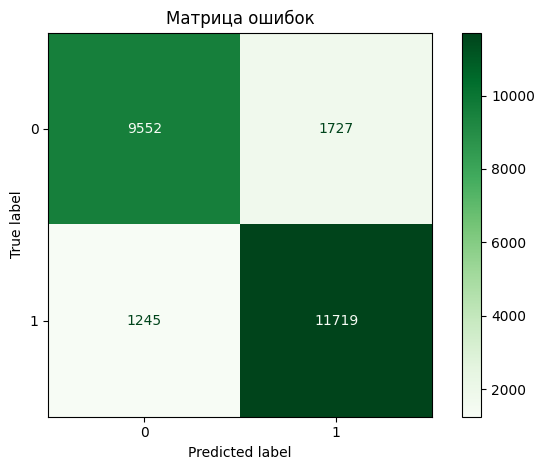

Метрики Градиентного бустинга регрессии: 
MAE - 14.80217834125711 
R^2 - 0.9242481807201262
RMSE - 42.18542966656711



In [117]:
pred_class = model_class.predict(X_test_classification)
metrics_class(y_test_classification, pred_class)

pred = model_reg.predict(X_test_reg)
metric_reg(y_test_reg, pred)

Метрики Самодельного Градиентного бустинга классификации на новом бейзлайне:
- Accuracy - 0.877
- f1 - 0.887
##### Метрики классификации в данном случае показали себя хуже среди всей моделей Градиентного бустинга, но это всё ещё хороший результат

Метрики Самодельного Случайного леса Регрессии на новом бейзлайне:
- MAE - 14.80
- R^2 - 0.92
- RMSE - 42.185
##### Метрики Регрессии показали себя очень хорошо. Средняя абсолютная ошибка всего 14.

Посмотрим лучшие гиперпараметры моделей для наших данных и применим их к нашим новым моделям

In [54]:
print(f'Лучшие параметры для задачи регрессии:{grid_reg.best_params_}')
print(f'Лучшие параметры для задачи Классификации:{grid_class.best_params_}')

Лучшие параметры для задачи регрессии:{'learning_rate': 0.07, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 100, 'subsample': 0.9}
Лучшие параметры для задачи Классификации:{'learning_rate': 0.07, 'max_depth': 5, 'min_samples_split': 50, 'n_estimators': 100, 'subsample': 0.9}


In [56]:
reg_model_second = GradientBoosting(task="regression", max_depth=grid_reg.best_params_['max_depth'], 
                                                       min_samples_split=grid_reg.best_params_['min_samples_split'], 
                                                       n_estimators=grid_reg.best_params_['n_estimators'],
                                                       learning_rate=grid_reg.best_params_['learning_rate'])
reg_model_second.fit(X_train_reg, y_train_reg)

In [57]:
class_model_second = GradientBoosting(task="classification", max_depth=grid_class.best_params_['max_depth'], 
                                                       min_samples_split=grid_class.best_params_['min_samples_split'], 
                                                       n_estimators=grid_class.best_params_['n_estimators'],
                                                       learning_rate=grid_class.best_params_['learning_rate'])

class_model_second.fit(X_train_classification, y_train_classification)

Метрики Градиентного бустинга для классификации: 
Accuracy - 0.9292991791444953 
f1 - 0.9342690596717288



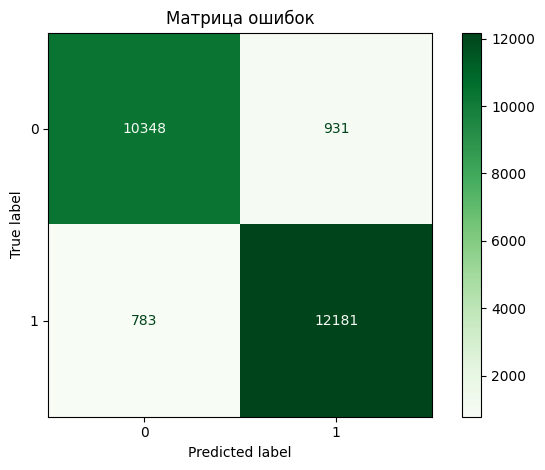

Метрики Градиентного бустинга регрессии: 
MAE - 12.451392446264922 
R^2 - 0.805881463387282
RMSE - 67.53041948024686



In [58]:
pred_second_class = class_model_second.predict(X_test_classification)
pred_second_reg = reg_model_second.predict(X_test_reg)
metrics_class(y_test_classification, pred_second_class)
metric_reg(y_test_reg, pred_second_reg)

Метрики для нашего самодельного Градиентного бустинга классификация в новом бейзлайне:
- Accuracy - 0.929
- f1 - 0.934
##### Метрики выросли в сравнении с прошлым бейзлайном, но не смогли обогнать многие модели из других лабораторных, но результат хороший

Метрики для нашего самодельного Градиентного бустинга для регрессии в новом бейзлайне:
- MAE - 12.45
- R^2 - 0.805
- RMSE - 67.53
##### Ситуация с регрессией идентична с Классификацией, показали метрик очень хорошие, но некоторые модели показали себя лучше

# Вывод по проделанной работе

В ходе лабораторной работы мы научились работать и изучили такую модель ансамбля как Градиентный бустинг. Градиентный бустинг работает по принципу - каждая последующая модель становится лучше, путём исправления ошибок прошлой модели. В данной работе мы сначала взяли модель из sklearn и обучили её на нашем базовом бейзлайне, далее составили новый бейзлайн. В нём было решено лишь подобрать гиперпараметры и cv. Далее мы написали собственный класс Градиентного бустинга и проверили на нём обе бейзлана, в задаче классификации лучше всех справилась наша модель на новом безлайне, тк модель из sklearn сильно переобучалась в обоих случаях. В задаче регрессии же лучше всех справилась модель из sklearn на новом безлайне.